### Monte Carlo Simulation for estimating pi

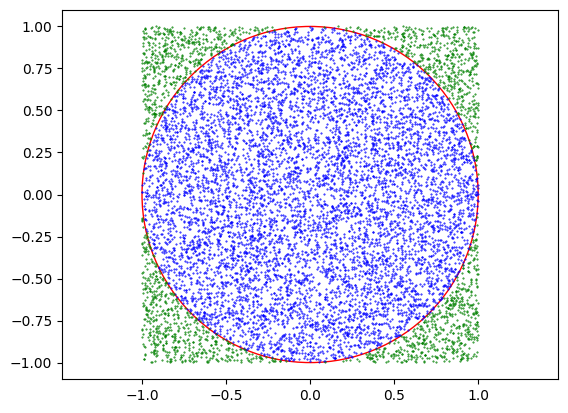

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque


# Estimate pi using Monte Carlo Simulation
N = 10000

inside = deque(maxlen=N)
outside = deque(maxlen=N)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
for i in range(N):

    x = np.random.uniform(-1, 1)
    y = np.random.uniform(-1, 1)
    if x**2 + y**2 <= 1:
        inside.append((x, y))
    else:
        outside.append((x, y))

inside = np.array(inside)
outside = np.array(outside)

plt.gca().add_artist(circle)
plt.scatter(inside[:, 0], inside[:, 1], color='b', s=0.2)
plt.scatter(outside[:, 0], outside[:, 1], color='g', s=0.2)

plt.axis('equal')
plt.show()

print ("pi:", 4 * len(inside) / (len(inside) + len(outside)), end='\r')

### Martingale Investment Strategy

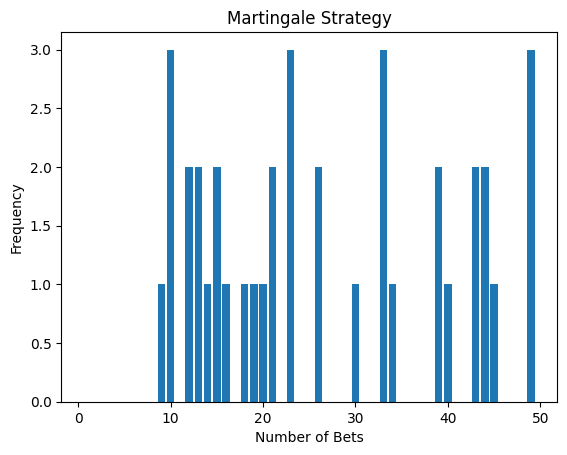

In [14]:
# Simulate Martingale Strategy
# Bet 1% of the current wealth

def simulate_martingale(initial_money, bet_amount, win_probability):
    money = initial_money
    num_bets = 0
    initial_bet_amount = bet_amount

    while money > 0:
        num_bets += 1
        if np.random.random() < win_probability:
            money += bet_amount
            bet_amount = initial_bet_amount
        else:
            money -= bet_amount
            bet_amount *= 2

            if bet_amount > money:
                break

    return num_bets

def calculate_distribution(initial_money, bet_amount, win_probability, num_simulations):
    num_bets_list = []

    for i in range(num_simulations):
        num_bets = simulate_martingale(initial_money, bet_amount, win_probability)
        num_bets_list.append(num_bets)

    return num_bets_list


# Parameters
initial_money = 10000
bet_amount = 10
win_probability = 0.5
num_simulations = 1000

# Calculate distribution
num_bets_list = calculate_distribution(initial_money, bet_amount, win_probability, num_simulations)

# Plot histogram, assume overflow bin is 20
plt.hist(num_bets_list, bins=range(1, 51), align='left', rwidth=0.8)
plt.xlabel('Number of Bets')
plt.ylabel('Frequency')
plt.title('Martingale Strategy')
plt.show()

### Download Data and fit GARCH

In [15]:
# Download data from Yahoo Finance
import os
import pandas as pd
import yfinance as yf
import arch

tickers = ['SPY', 'QQQ']

holder = {}
for ticker in tickers:

    file_name = f'{ticker}.csv'
    if not os.path.exists(file_name):
        df = yf.Ticker(ticker).history(start='2018-01-01', end='2023-12-31')
        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True)
    df.index = df.index.tz_convert('US/Eastern')

    holder[ticker] = df

spy = holder['SPY']
qqq = holder['QQQ']

# Calculate daily returns
spy['daily_return'] = spy['Close'].pct_change()
qqq['daily_return'] = qqq['Close'].pct_change()

# Last day's return
print("SPY", spy['daily_return'].iloc[-1])
print("QQQ", qqq['daily_return'].iloc[-1])

# Fit GARCH model
# garch = arch.arch_model(spy['daily_return'].dropna()*100, vol='Garch', p=1, q=1)
# garch_fitted = garch.fit(disp='off')

# print(garch_fitted.summary())

# garch = arch.arch_model(qqq['daily_return'].dropna()*100, vol='Garch', p=1, q=1)
# garch_fitted = garch.fit(disp='off')

# print(garch_fitted.summary())

# Find Historical VaR
spy_var = spy['daily_return'].dropna().quantile(0.05)
qqq_var = qqq['daily_return'].dropna().quantile(0.05)
print("SPY VaR", spy_var, "QQQ VaR", qqq_var)

spy_vol = spy['daily_return'].dropna().std()
qqq_vol = qqq['daily_return'].dropna().std()
print("SPY Vol", spy_vol, "QQQ Vol", qqq_vol)


SPY -0.002894977560712997
QQQ -0.0043277403326080766
SPY VaR -0.019626398746664286 QQQ VaR -0.025679832737828565
SPY Vol 0.012843644089854807 QQQ Vol 0.01575010999123147


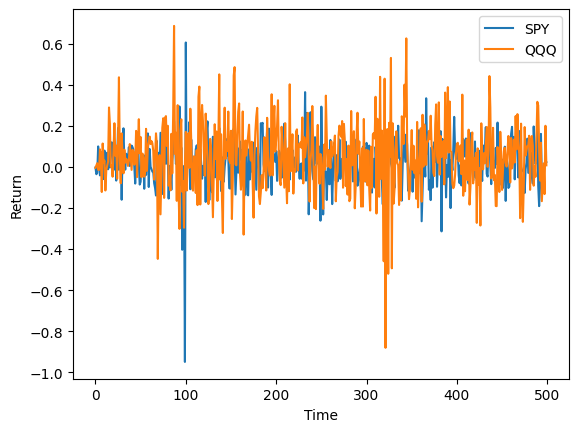

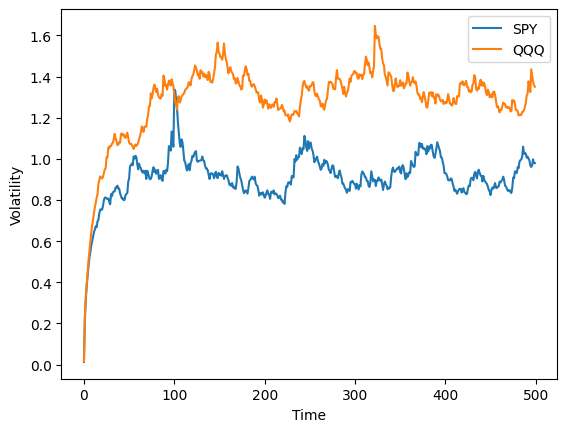

In [19]:
spy_garch = {'omega': 0.0476, 'alpha': 0.2037, 'beta': 0.7730, 'last_day_return': -0.00289, 'last_day_std': 0.01284}
qqq_garch = {'omega': 0.0544, 'alpha': 0.1599, 'beta': 0.8247, 'last_day_return': -0.00432, 'last_day_std': 0.01575}

# Simulate term structure of volatility using GARCH model and Monte Carlo Simulation
# We simulate the returns of the stock using the GARCH model
N = 100
T = 500

holder = []
def simulate_garch(omega, alpha, beta, last_day_return, last_day_std, N, T, df = None):

    df['z'] = df['daily_return'] / df['daily_return'].std()
    z = list(df['z'].dropna().values)

    simulation_return_holder = []
    simulation_volatility_holder = []
    for i in range(N):
        volatility_holder = []
        returns_holder = []

        for t in range(T):
            if t == 0:
                returns_holder.append(last_day_return)
                volatility_holder.append(last_day_std)

            else:
                # shock = np.random.normal(0, 1)
                
                # FHS
                shock = np.random.choice(z)
                
                conditional_volatility = np.sqrt(omega + alpha * returns_holder[-1]**2 + beta * volatility_holder[-1]**2)
                simulated_return = shock * conditional_volatility

                returns_holder.append(simulated_return)
                volatility_holder.append(conditional_volatility)

        simulation_return_holder.append(returns_holder)
        simulation_volatility_holder.append(volatility_holder)

    return simulation_return_holder, simulation_volatility_holder

spy_simulation, spy_vol_sim = simulate_garch(**spy_garch, N=N, T=T, df = spy)
qqq_simulation, qqq_vol_sim = simulate_garch(**qqq_garch, N=N, T=T, df = qqq)

# Plot the simulation
plt.plot(np.mean(spy_simulation, axis=0), label='SPY')
plt.plot(np.mean(qqq_simulation, axis=0), label='QQQ')

plt.xlabel('Time')
plt.ylabel('Return')

plt.legend()
plt.show()

# Plot the volatility simulation
plt.plot(np.mean(spy_vol_sim, axis=0), label='SPY')
plt.plot(np.mean(qqq_vol_sim, axis=0), label='QQQ')

plt.xlabel('Time')
plt.ylabel('Volatility')

plt.legend()
plt.show()

### Get the VaR for each day

After: 22 SPY VaR -0.2429857987272493
After: 22 QQQ VaR -0.25886040307441505


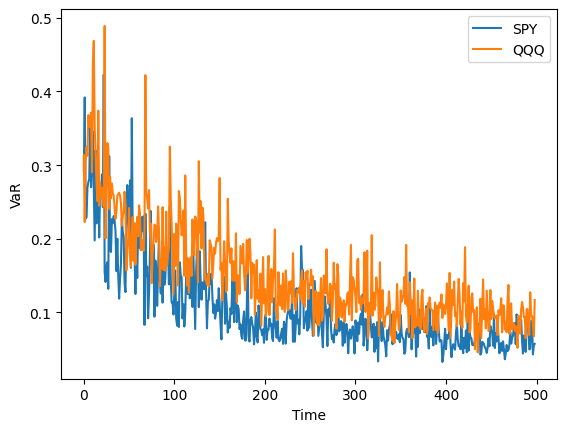

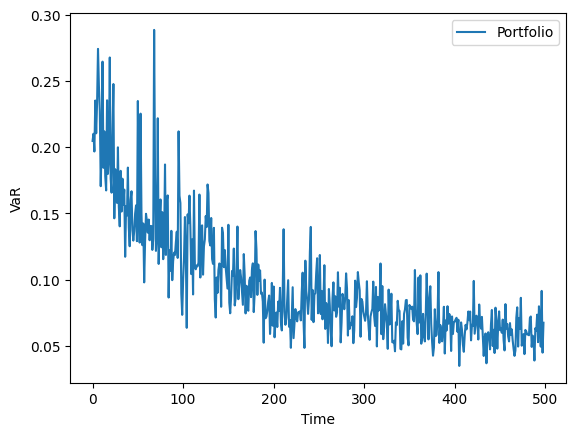

After: 22 Portfolio VaR -0.16568336261566274


In [21]:
# Given the simulated returns using MCS, fine the VaR for each day
spy_simulation = np.array(spy_simulation)
qqq_simulation = np.array(qqq_simulation)

# Make spy_simulation and qqq_simulation 1d array
spy_simulation_flattened = spy_simulation.flatten()
qqq_simulation_flattened = qqq_simulation.flatten()

spy_VaR = np.percentile(spy_simulation_flattened, 5, axis=0)
qqq_VaR = np.percentile(qqq_simulation_flattened, 5, axis=0)

spy_VaR_holder = []
qqq_VaR_holder = []

for t in range(T):
    if t == 0:
        continue
    spy_VaR_holder.append(-np.percentile(spy_simulation[0:, t]/np.sqrt(t+1), 5))
    qqq_VaR_holder.append(-np.percentile(qqq_simulation[0:, t]/np.sqrt(t+1), 5))

def get_VaR_at_time(t, simulation, alpha):
    return np.percentile(simulation[:, t], alpha)

t = 22
print ("After:", t, "SPY VaR", get_VaR_at_time(t, spy_simulation/np.sqrt(t+1), 5))
print ("After:", t, "QQQ VaR", get_VaR_at_time(t, qqq_simulation/np.sqrt(t+1), 5))

plt.plot(spy_VaR_holder, label='SPY')
plt.plot(qqq_VaR_holder, label='QQQ')

plt.xlabel('Time')
plt.ylabel('VaR')

plt.legend()
plt.show()


portfolio_simulation = (spy_simulation + qqq_simulation)/2
portfolio_VaR_holder = []
for t in range(T):
    if t == 0:
        continue
    portfolio_VaR_holder.append(-np.percentile(portfolio_simulation[0:, t]/np.sqrt(t+1), 5))

plt.plot(portfolio_VaR_holder, label='Portfolio')

plt.xlabel('Time')
plt.ylabel('VaR')

plt.legend()
plt.show()

t = 22
print ("After:", t, "Portfolio VaR", get_VaR_at_time(t, portfolio_simulation/np.sqrt(t+1), 5))


### With correlation

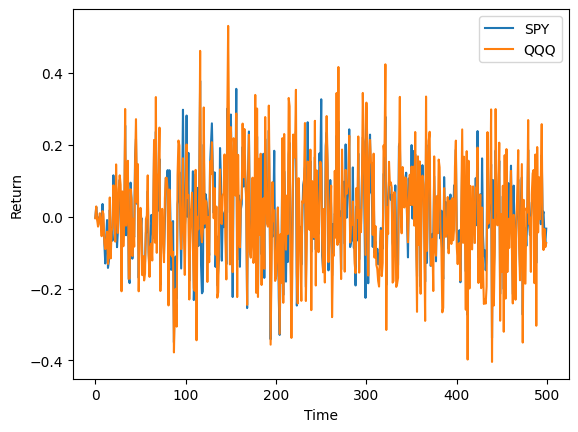

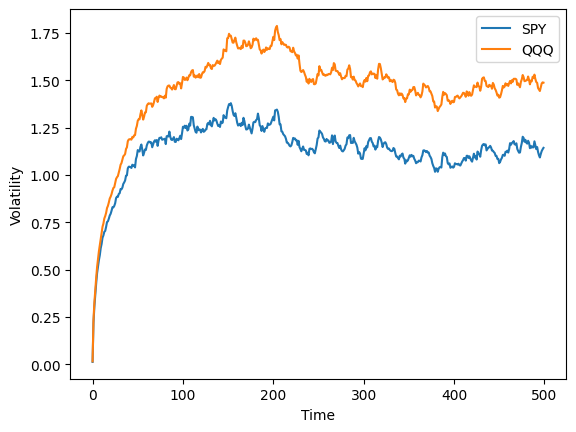

In [43]:
spy_garch = {'omega': 0.0476, 'alpha': 0.2037, 'beta': 0.7730, 'last_day_return': -0.00289, 'last_day_std': 0.01284}
qqq_garch = {'omega': 0.0544, 'alpha': 0.1599, 'beta': 0.8247, 'last_day_return': -0.00432, 'last_day_std': 0.01575}

returns_df = pd.DataFrame({'SPY': spy['daily_return'], 'QQQ': qqq['daily_return']})
returns_df = returns_df.dropna()

returns_df_z = (returns_df - returns_df.mean()) / returns_df.std()
cov_matrix = returns_df_z.cov()
cholesky_decomposition = np.linalg.cholesky(cov_matrix)

cholesky_decomposition = np.linalg.cholesky(cov_matrix)
# Simulate term structure of volatility using GARCH model and Monte Carlo Simulation
# We simulate the returns of the stock using the GARCH model
N = 100
T = 500

holder = []
def simulate_garch(spy_garch, spy_df, qqq_garch, qqq_df, N, T):

    spy_df['z'] = spy_df['daily_return'] / spy_df['daily_return'].std()
    qqq_df['z'] = qqq_df['daily_return'] / qqq_df['daily_return'].std()

    simulation_return_holder = {}
    simulation_return_holder['SPY'] = []
    simulation_return_holder['QQQ'] = []

    simulation_volatility_holder = {}
    simulation_volatility_holder['SPY'] = []
    simulation_volatility_holder['QQQ'] = []

    for i in range(N):
        returns_holder = {'SPY': [], 'QQQ': []}
        volatility_holder = {'SPY': [], 'QQQ': []}

        for t in range(T):

            # Generate correlated random variables using normal distribution
            z_spy = np.random.normal(0, 1)
            z_qqq = np.random.normal(0, 1)
            z_spy, z_qqq = np.dot(cholesky_decomposition, np.array([z_spy, z_qqq]))

            # FHS
            # random_date = np.random.choice(returns_df.index)
            # z_spy = spy_df.loc[random_date, 'z']
            # z_qqq = qqq_df.loc[random_date, 'z']

            for ticker in ['SPY', 'QQQ']:

                garch = spy_garch if ticker == 'SPY' else qqq_garch
                shock = z_spy if ticker == 'SPY' else z_qqq

                omega = garch['omega']
                alpha = garch['alpha']
                beta = garch['beta']
                last_day_return = garch['last_day_return']
                last_day_std = garch['last_day_std']

                if t == 0:
                    returns_holder[ticker].append(last_day_return)
                    volatility_holder[ticker].append(last_day_std)

                else:
                    
                    conditional_volatility = np.sqrt(omega + alpha * returns_holder[ticker][-1]**2 + beta * volatility_holder[ticker][-1]**2)
                    simulated_return = shock * conditional_volatility

                    returns_holder[ticker].append(simulated_return)
                    volatility_holder[ticker].append(conditional_volatility)

        for ticker in ['SPY', 'QQQ']:
            simulation_return_holder[ticker].append(returns_holder[ticker])
            simulation_volatility_holder[ticker].append(volatility_holder[ticker])

    return simulation_return_holder, simulation_volatility_holder

sim_return_holder, sim_vol_holder = simulate_garch(spy_garch, spy, qqq_garch, qqq, N, T)
spy_simulation = np.array(sim_return_holder['SPY'])
qqq_simulation = np.array(sim_return_holder['QQQ'])

# Plot the simulation
plt.plot(np.mean(spy_simulation, axis=0), label='SPY')
plt.plot(np.mean(qqq_simulation, axis=0), label='QQQ')

plt.xlabel('Time')
plt.ylabel('Return')

plt.legend()
plt.show()

spy_vol_sim = np.array(sim_vol_holder['SPY'])
qqq_vol_sim = np.array(sim_vol_holder['QQQ'])
# Plot the volatility simulation
plt.plot(np.mean(spy_vol_sim, axis=0), label='SPY')
plt.plot(np.mean(qqq_vol_sim, axis=0), label='QQQ')

plt.xlabel('Time')
plt.ylabel('Volatility')

plt.legend()
plt.show()

# VaR

After: 22 SPY VaR -0.26347083368015717
After: 22 QQQ VaR -0.30348183758613484


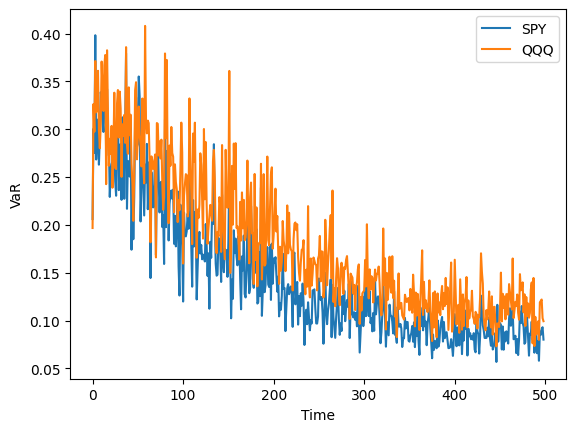

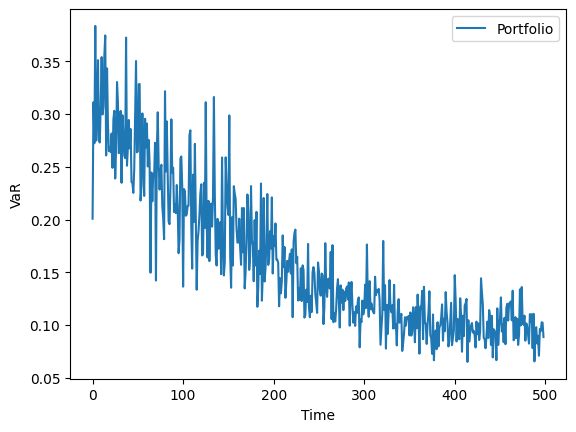

After: 22 Portfolio VaR -0.2816038576375653


In [44]:
# Given the simulated returns using MCS, fine the VaR for each day
spy_simulation = np.array(spy_simulation)
qqq_simulation = np.array(qqq_simulation)

# Make spy_simulation and qqq_simulation 1d array
spy_simulation_flattened = spy_simulation.flatten()
qqq_simulation_flattened = qqq_simulation.flatten()

spy_VaR = np.percentile(spy_simulation_flattened, 5, axis=0)
qqq_VaR = np.percentile(qqq_simulation_flattened, 5, axis=0)

spy_VaR_holder = []
qqq_VaR_holder = []

for t in range(T):
    if t == 0:
        continue
    spy_VaR_holder.append(-np.percentile(spy_simulation[0:, t]/np.sqrt(t+1), 5))
    qqq_VaR_holder.append(-np.percentile(qqq_simulation[0:, t]/np.sqrt(t+1), 5))

def get_VaR_at_time(t, simulation, alpha):
    return np.percentile(simulation[:, t], alpha)

t = 22
print ("After:", t, "SPY VaR", get_VaR_at_time(t, spy_simulation/np.sqrt(t+1), 5))
print ("After:", t, "QQQ VaR", get_VaR_at_time(t, qqq_simulation/np.sqrt(t+1), 5))

plt.plot(spy_VaR_holder, label='SPY')
plt.plot(qqq_VaR_holder, label='QQQ')

plt.xlabel('Time')
plt.ylabel('VaR')

plt.legend()
plt.show()


portfolio_simulation = (spy_simulation + qqq_simulation)/2
portfolio_VaR_holder = []
for t in range(T):
    if t == 0:
        continue
    portfolio_VaR_holder.append(-np.percentile(portfolio_simulation[0:, t]/np.sqrt(t+1), 5))

plt.plot(portfolio_VaR_holder, label='Portfolio')

plt.xlabel('Time')
plt.ylabel('VaR')

plt.legend()
plt.show()

t = 22
print ("After:", t, "Portfolio VaR", get_VaR_at_time(t, portfolio_simulation/np.sqrt(t+1), 5))